In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

# Display dataset 1

In [2]:
df = pd.read_csv('data/dataset1.csv')

print(df.head())

   Col0  Col1  Col2  Col3  Col4  Col5  Col6  Col7  Col8  Col9  Col10  Col11  \
0   -98  -109  -104  -101  -109  -104  -107  -105  -107  -105    -98   -102   
1   -98  -110  -101  -106  -100  -107   -98  -107  -100  -100   -105   -107   
2  -106  -101  -109  -109  -106  -101  -111  -104  -102  -108   -106   -104   
3  -107  -106  -101  -106  -104  -104  -111  -103  -106  -102   -100    -99   
4  -100  -103  -109  -104  -102  -109  -107  -105  -103  -107   -104   -104   

   Col12  Col13  Col14  Col15  
0   -104   -104   -106   -103  
1    -98   -101   -102   -102  
2   -108    -98    -95   -103  
3   -109   -106   -100   -102  
4   -109   -104    -96    -95  


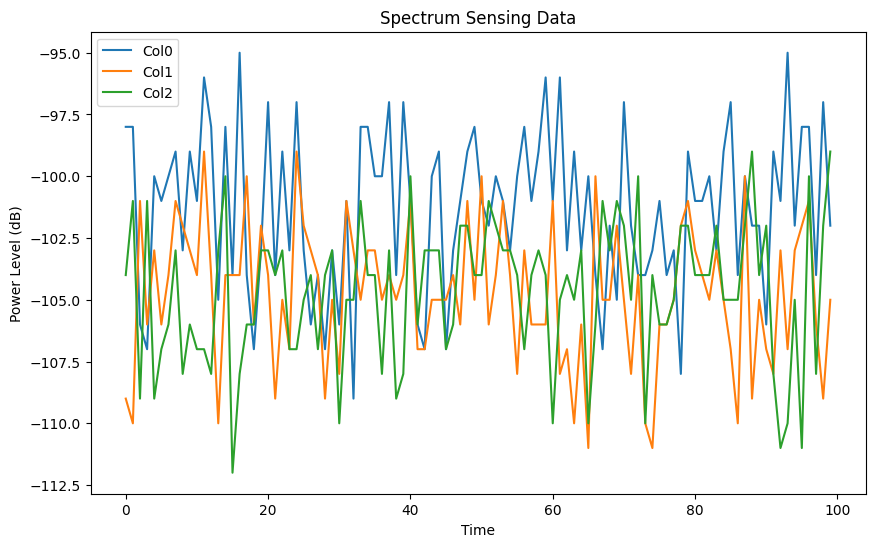

In [3]:
plt.figure(figsize=(10, 6))

for col in df.columns[:3]:
    plt.plot(df[col][:100], label=col)

# Add title and labels
plt.title('Spectrum Sensing Data')
plt.xlabel('Time')  # Adjust according to your data
plt.ylabel('Power Level (dB)')

# Add legend to show which line corresponds to which column
plt.legend()

# Display the plot
plt.show()

# Display dataset 2

In [4]:
df = pd.read_csv('data/dataset2.csv')

print(df.head())

   0  33.1  30.3  24.4  25.9  33.1.1  28.2  27.9
0  1  24.3  35.1  27.4  35.2    22.4  29.9  30.7
1  2  26.7  34.2  24.3  30.7    24.7  29.4  28.2
2  3  25.6  32.9  25.9  34.4    22.5  29.5  27.6
3  4  27.1  34.1  26.0  33.8    23.4  30.3  28.2
4  5  26.4  34.7  25.0  30.3    25.8  27.6  27.2


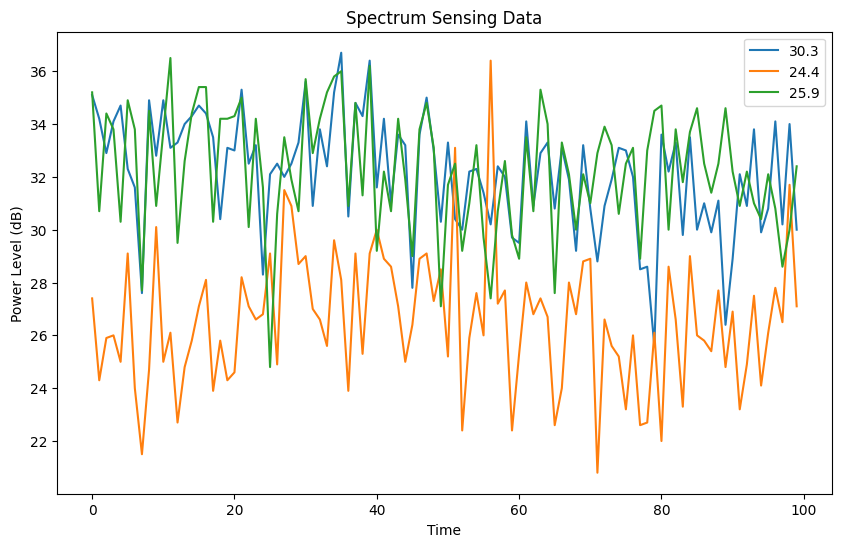

In [5]:
plt.figure(figsize=(10, 6))

for col in df.columns[2:5]:
    plt.plot(df[col][:100], label=col)

# Add title and labels
plt.title('Spectrum Sensing Data')
plt.xlabel('Time')  # Adjust according to your data
plt.ylabel('Power Level (dB)')

# Add legend to show which line corresponds to which column
plt.legend()

# Display the plot
plt.show()

# Basic pytorch setup

In [6]:
# Connect torch to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print the device being used
print('Using device:', device)

Using device: cuda


In [7]:
# Load data
df = pd.read_csv('data/dataset1.csv')

# Convert to numpy arrays
nn_input = []

# Split each frequency into a list of data for input to the neural network
for column in df.columns:
    nn_input.append(df[column].to_list())
    
# Place data in numpy array
nn_input = np.array(nn_input)

nn_input = nn_input.T

In [8]:
data = torch.FloatTensor(nn_input)

# Neural network input
input_size = data.shape[1]  # Number of features (3 in this case)
hidden_size = data.shape[1] / 4  # Size of LSTM hidden state
num_layers = 3  # Number of LSTM layers
output_size = 1  # Predict one value
num_epochs = 5000
learning_rate = 0.01

In [9]:
# Create sequences and labels for training
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# Parameters
seq_length = 12
sequences, labels = create_sequences(data, seq_length)

sequences = sequences.to(device)
labels = labels.to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Fully connected on the last output
        return out

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Training loop
for epoch in range(num_epochs):
    outputs = model(sequences)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test prediction for the next value in the sequence
with torch.no_grad():
    test_input = data[-seq_length:].unsqueeze(0).to(device)  # Use the last 3 values
    predicted_value = model(test_input)
    print(f'Predicted next value: {predicted_value.item()}')

/home/larsvonk/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([67311, 16])) that is different to the input size (torch.Size([67311, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
